# Problema

Problema propune gasirea celor mai bune modele pentru clasificarea unor imagini care contin numere intre 0 si 255 (256 clase) in numerele respective folosind tensorflow si convolutional neural networks.

A doua parte a problemei presupune folosirea de recurent neural network pentru a calcula suma a 2 numere.

In [268]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, RepeatVector
from keras.optimizers import Adam, SGD
import data_generator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Task1

Task-ul 1 presupune predictia numerelor prezente in imagini de 28x84 pixeli. Numerele perezente in imagini au valori intre 0 si 255 (deci 256 clase)

## O serie de metode utilizate pentru exercitiul 1 (o parte si pentru ex 2)

In [212]:
# Useful functions
def save_model(model, path):
    model.save(path)

def load_model(path):
    return load_model(path)

def generate_data(number_of_training_pairs=10000, number_of_test_pairs=512): # training and test data will be *2 those
    training_set = data_generator.training_generator(number_of_training_pairs)
    test_set = data_generator.test_generator(number_of_test_pairs)
    X, y, y_sum = next(training_set)
    X_test, y_test, y_sum_test = next(test_set)

    X1 = [el[0] for el in X]
    X2 = [el[1] for el in X]
    X = np.array(X1 + X2)

    y1 = [el[0] for el in y]
    y2 = [el[1] for el in y]
    y = np.array(y1 + y2)

    X1 = [el[0] for el in X_test]
    X2 = [el[1] for el in X_test]
    X_test = np.array(X1 + X2)

    y1 = [el[0] for el in y_test]
    y2 = [el[1] for el in y_test]
    y_test = np.array(y1 + y2)
    return X, y, X_test, y_test

def reshape_and_normalize(X, y, X_test, y_test):
    # constants
    number_of_classes = 256
    data_height = 28
    data_width = 84

    # normalization
    X = X / 255.0
    X_test = X_test / 255.0

    y = keras.utils.to_categorical(y, number_of_classes)
    y_test = keras.utils.to_categorical(y_test, number_of_classes)

    # prepare data
    X = X.reshape(X.shape[0], data_height, data_width, 1)
    X_test = X_test.reshape(X_test.shape[0], data_height, data_width, 1)
    return X, y, X_test, y_test

# creates a model where we vary optimizers (2 possibilities: sgd or adam) and their learning rates
# More about the model architecture below
def create_model(optimizer, lr): # optimizer is a string can be "adam" or "sgd"
    # needed constants
    number_of_classes = 256
    data_height = 28
    data_width = 84
    input_shape = X.shape[1:]
    
    # create optimizer (the only thing that varies and we are trying to tune)
    # it can be either SGD or Adam and it can have variable learning rate
    if optimizer == "sgd":
        my_optimizer = SGD(lr=lr)
    elif optimizer == "adam":
        my_optimizer = Adam(lr=lr)
    else:
        my_optimizer = "adam" # make the optimizer default adam if an unknown is being specified

    # model
    model = Sequential()

    # Layer 1
    model.add(Conv2D(16, (5, 5), padding="SAME", input_shape=input_shape, kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # Layer 2
    model.add(Conv2D(32, (3, 3), padding="SAME", kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(64, (5, 5), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # Layer 4
    model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 5
    model.add(Conv2D(256, (3, 3), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # Layer 6
    model.add(Conv2D(128, (2, 2), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    # Layer 7
    model.add(Conv2D(64, (1, 1), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # Layer 8
    model.add(Conv2D(32, (1, 1), kernel_initializer="he_normal"))
    model.add(Activation('relu'))
    model.add(Flatten())
    
    # Layer 9
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    # Layer 10
    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=my_optimizer, metrics=['categorical_accuracy'])
    return model

def train_model(model, X, y):
    # number of epochs. Explained below. We will use all the time 10 epochs.
    epochs = 10
    batch_size = 32
    validation_split = 0.1 # percentage of data to be used for validation
    history = LossAccHistory()
    model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[history])
    return model, history
    
# class used to save history of the model (every batch loss value and accuracy value) - plot purposes
class LossAccHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('categorical_accuracy'))
        
def plot_losses_per_batch(history):
    plt.plot(range(len(history.losses)), history.losses)

def plot_accuracies_per_batch(history):
    plt.plot(range(len(history.accuracies)), history.accuracies)
    
def evaluate_all_models(models, X_test, y_test):
    batch_size=32
    for index, model_info in enumerate(models):
        model = model_info["model"]
        accuracy_and_loss = model.evaluate(X_test, y_test, batch_size=batch_size)
        model_info["accuracy"] = accuracy_and_loss[1]
        models[index] = model_info
        print("Params: ", model_info["params"])
        print("[Loss, Accuracy]: ", accuracy_and_loss)
    return models


# Generarea setului de date

S-au generat 15.000 perechi de numere pentru antrenare (adica 30.000 imagini cu numere) si 1000 perechi de test (adica 2000 numere). Perechile de test au fost folosite pentru a evalua modelele.

Aceste date au fost normalizate. In cazul inputului, vorbind de pixeli, fiecare valoare a fost impartita la 255.0 si s-a facut un reshape adaugand channel-ul (vorbind de imagini alb negru, channel-ul va fi 1).
In cazul label-urilor acestea au fost transformate in one hot (array cu 256 elemente, doar unul din ele avand valoarea 1).

In [190]:
# generate data
X, y, X_test, y_test = generate_data(number_of_training_pairs=15000, number_of_test_pairs=1000) # 30k images for train. 2000 images for evaluation
# reshape data and normalize it
X, y, X_test, y_test = reshape_and_normalize(X, y, X_test, y_test)
print("Train X shape:", X.shape)
print("Train y shape:", y.shape)
print("Test X shape:", X_test.shape)
print("Test y shape:", y_test.shape)

Train X shape: (30000, 28, 84, 1)
Train y shape: (30000, 256)
Test X shape: (2000, 28, 84, 1)
Test y shape: (2000, 256)


Au fost generate 10 imagini cu numere pentru a intelege cum arata acestea.

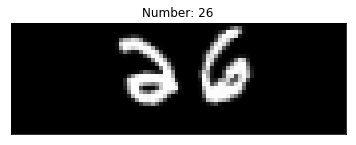

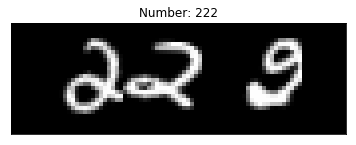

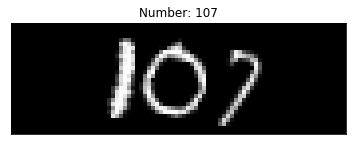

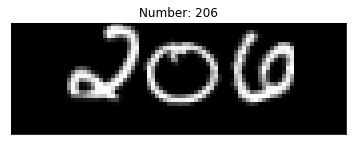

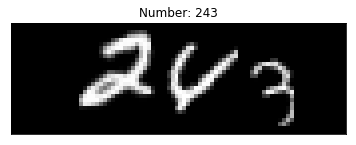

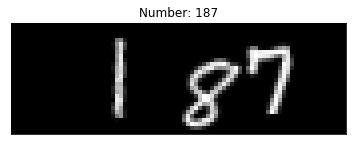

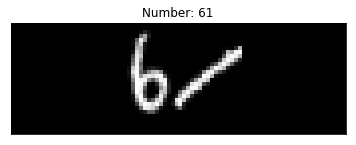

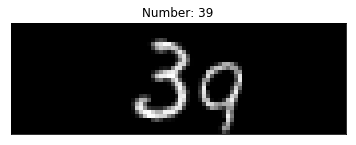

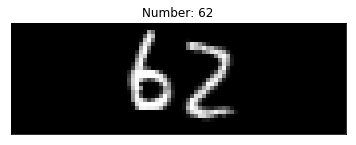

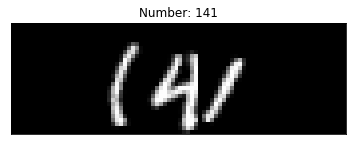

In [207]:
X_to_plot, y_to_plot, X_test_to_plot, y_test_to_plot = generate_data(5, 0)
for i in range(10):
    fig = plt.figure(i)
    plt.tight_layout()
    plt.imshow(X_to_plot[i], cmap='gray', interpolation='none')
    plt.title("Number: {}".format(y_to_plot[i]))
    plt.xticks([])
    plt.yticks([])

# Modele (variatia hyperparametrilor)

A fost luat in considerare un singur model pentru care s-a variat optimizer-ul (sgd sau adam) unde s-a variat learning rate-ul.

# Structura modelului

Modelul contine 10 layere. 
Layerele 1 pana la 8 contin Convolutional Layers care aplica un filtru de diferite dimensiuni ((5, 5), (3, 3) etc.) pe imagini si trimite output-ul catre layer-ul urmator.
In toate cazurile a fost folosit ca Activation function "relu" si kernel_initializer "he_normal".
In cazul layerelor 2 si 4 s-a facut un MaxPooling care, din matricea rezultata, ia valorile maxime din zone de 2 x 2 pixeli.

Dupa layer-ul 8 s-a folosit metoda Flatten care, din matricea rezultata creeaza un array cu o singura dimensiune.
Acest layer este urmat de 2 layer-e Dense(512) si Dense(256) care reduc dimensionalitatea array-ului de input la 512 respectiv 256. Am ales sa fac acest lucru in 2 layere pentru ca am observat un comportament ciudat atunci cand reduceam direct la 256.

Pe ultimul layer a fost folosita functia "softmax" ca activation function.

Ca si functie de loss a fost folosita "categorical_crossentropy", iar metrica dupa care se valideaza cat de bun este modelul este "categorical_accuracy".

Optimizerul, cum am mentionat mai sus, variaza intre sgb si adam cu learning rate variabil.

In [191]:
# create models with their respective params
models = []
parameters = [{"optimizer": "sgd", "lr": 0.001}, 
              {"optimizer": "sgd", "lr": 0.01},
              {"optimizer": "sgd", "lr": 0.1},
              {"optimizer": "adam", "lr": 0.001},
              {"optimizer": "adam", "lr": 0.01},
              {"optimizer": "adam", "lr": 0.1}]
for params in parameters:
    models.append({"model": create_model(**params),
                   "params": params,
                   "history": None,
                   "Accuracy": None
                  })
print("Number of models to test: ", len(models))

Number of models to test:  6


# Antrenarea modelelor

Modelele au fost antrenate pe datele de antrenare (X, y) si s-au folosit 10% din acestea ca validation data. 

Toate modelel au fost antrenate pentru 10 epoci.

## Tin sa mentionez ca laptopul pe care am lucrat are o placa video Intel, astfel NU am putut rula antrenarea pe GPU intrucat, conform documentatiei oficiale, tensorflow poate rula pe GPU doar pe placi video NVIDIA. Acesta este motivul pentru care nu am variat mai multi hyperparametrii si am optat pentru mai putina variatie. Rularea antrenarii a durat aproximativ 6 ore.

Am decis sa pastrez, pentru fiecare batch, accuracy si loss pentru fiecare model (au fost mai jos salvate intr-un fisier) pentru a putea face un plot cu acestea

In [192]:
# train all the models and save their history
for index, model_info in enumerate(models):
    print("Training model with params: ", model_info["params"])
    model, history = train_model(model_info["model"], X, y)
    model_info["history"] = history
    model_info["model"] = model
    models[index] = model_info
    # also save models after training them
    save_model(model=model, path="model_number_{}.h5".format(index))

Training model with params:  {'optimizer': 'sgd', 'lr': 0.001}
Train on 27000 samples, validate on 3000 samples
Epoch 1/10
27000/27000 [==============================] - 354s 13ms/step - loss: 5.6016 - categorical_accuracy: 0.0050 - val_loss: 5.5689 - val_categorical_accuracy: 0.0043
Epoch 2/10
27000/27000 [==============================] - 352s 13ms/step - loss: 5.5121 - categorical_accuracy: 0.0081 - val_loss: 5.5147 - val_categorical_accuracy: 0.0077
Epoch 3/10
27000/27000 [==============================] - 356s 13ms/step - loss: 5.4369 - categorical_accuracy: 0.0163 - val_loss: 5.4495 - val_categorical_accuracy: 0.0140
Epoch 4/10
27000/27000 [==============================] - 371s 14ms/step - loss: 5.3420 - categorical_accuracy: 0.0229 - val_loss: 5.3509 - val_categorical_accuracy: 0.0197
Epoch 5/10
27000/27000 [==============================] - 351s 13ms/step - loss: 5.2062 - categorical_accuracy: 0.0302 - val_loss: 5.2036 - val_categorical_accuracy: 0.0253
Epoch 6/10
27000/27000 

27000/27000 [==============================] - 352s 13ms/step - loss: 5.5471 - categorical_accuracy: 0.0041 - val_loss: 5.5501 - val_categorical_accuracy: 0.0030
Epoch 6/10
27000/27000 [==============================] - 355s 13ms/step - loss: 5.5467 - categorical_accuracy: 0.0046 - val_loss: 5.5517 - val_categorical_accuracy: 0.0030
Epoch 7/10
27000/27000 [==============================] - 361s 13ms/step - loss: 5.5470 - categorical_accuracy: 0.0041 - val_loss: 5.5503 - val_categorical_accuracy: 0.0017
Epoch 8/10
27000/27000 [==============================] - 360s 13ms/step - loss: 5.5469 - categorical_accuracy: 0.0041 - val_loss: 5.5499 - val_categorical_accuracy: 0.0043
Epoch 9/10
27000/27000 [==============================] - 365s 14ms/step - loss: 5.5469 - categorical_accuracy: 0.0037 - val_loss: 5.5512 - val_categorical_accuracy: 0.0043
Epoch 10/10
27000/27000 [==============================] - 364s 13ms/step - loss: 5.5471 - categorical_accuracy: 0.0040 - val_loss: 5.5503 - val_c

# Evaluarea modelelor

Modelele au fost evaluate pe datele de test generate mai sus.
Cele mai bune rezultate au fost gasite in cazul folosirii optimizer-ului SGD cu learning rate 0.1 care are o acuratele de 96.85%, urmat de modelul cu optimizer Adam cu learning rate 0.001 care are o acuratele de 95.5% si de modelul cu optimizer SGD cu learning rate 0.01.

Se observa ca in celelalte cazuri acuratetea este foarte mica.

In [193]:
# Evaluate all models
models = evaluate_all_models(models, X_test, y_test)

2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'sgd', 'lr': 0.001}
[Loss, Accuracy]:  [3.6365677604675293, 0.168]
2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'sgd', 'lr': 0.01}
[Loss, Accuracy]:  [0.22583162862062453, 0.9375]
2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'sgd', 'lr': 0.1}
[Loss, Accuracy]:  [0.1463817806299776, 0.9685]
2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'adam', 'lr': 0.001}
[Loss, Accuracy]:  [0.1905313082523644, 0.955]
2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'adam', 'lr': 0.01}
[Loss, Accuracy]:  [5.5469677543640135, 0.005]
2000/2000 [==============================] - 6s 3ms/step
Params:  {'optimizer': 'adam', 'lr': 0.1}
[Loss, Accuracy]:  [16.04556393432617, 0.0045]


# Plotarea loss-ului over time

Mai jos este plotata valoarea loss-ului din fiecare batch.

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


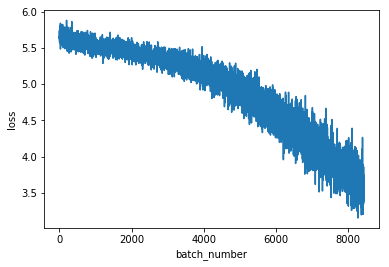

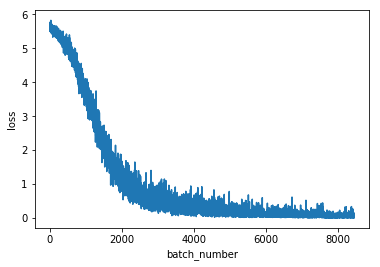

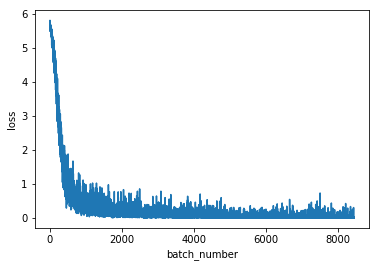

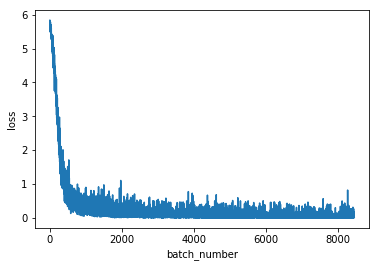

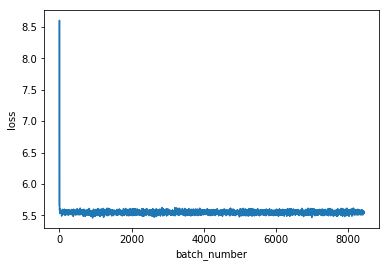

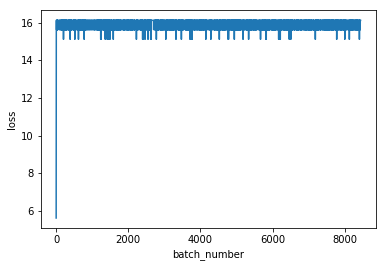

In [209]:
for i, model_info in enumerate(models):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("loss")
    plot_losses_per_batch(model_info["history"])

# Plotarea acuratetii over time

Mai jos este plotata valoarea acuratetii din fiecare batch.

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


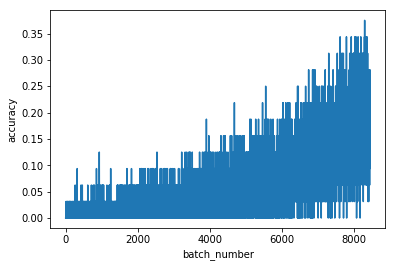

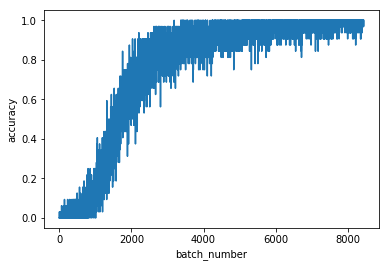

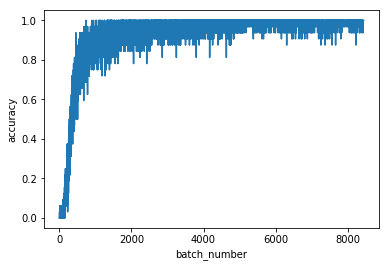

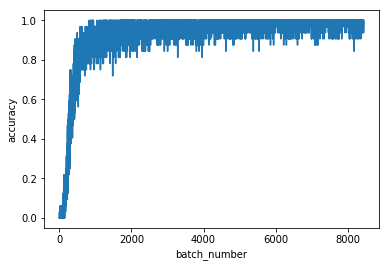

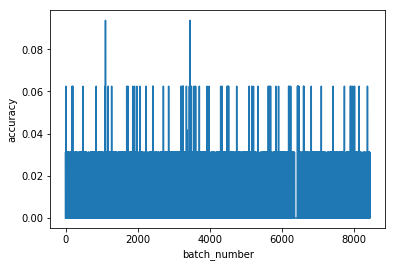

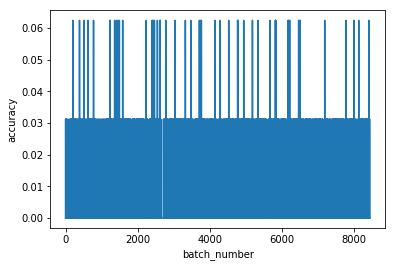

In [210]:
for i, model_info in enumerate(models):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("accuracy")
    plot_accuracies_per_batch(model_info["history"])

In [200]:
for i, model_info in enumerate(models):
    history = model_info['history']
    with open("history_loss_model{}.txt".format(i), "w") as file:
        file.write(str(history.losses))
    with open("history_acc_model{}.txt".format(i), "w") as file:
        file.write(str(history.accuracies))   

# Task 2

Task-ul 2 presupune folosirea de recurent neural networks pentru a calcula suma a doua numere

## O serie de functii utilizate pentru rezolvarea exercitiului 2

In [320]:
def generate_data_task2(number_of_training_pairs=10000, number_of_test_pairs=512): # training and test data will be *2 those
    training_set = data_generator.training_generator(number_of_training_pairs)
    test_set = data_generator.test_generator(number_of_test_pairs)
    X, y, y_sum = next(training_set)
    X_test, y_test, y_sum_test = next(test_set)

    # transform tuples (x, y) to array [x, y]
    # and get rid of numpy arrays so that we can use the encoding and decoding functions bellow
    
    y = [[el[0], el[1]] for el in y]
    y_sum = [list(el)[0] for el in y_sum]
    
    y_test = [[el[0], el[1]] for el in y_test]
    y_sum_test = [list(el)[0] for el in y_sum_test]
    return y, y_sum, y_test, y_sum_test

# transforms the input and output into string (with space translations at the end if necessary)
# example y = 10 => "10 "
# example X = [10, 122] => "10+122 "
def data_to_string(X, y): 
    max_length = len("255+255") # we can have maximum 255+255
    X_new = []
    for pattern in X:
        new_pattern = '+'.join([str(n) for n in pattern])
        new_pattern = new_pattern + ''.join([' ' for _ in range(max_length - len(new_pattern))])
        X_new.append(new_pattern)
    y_new = []
    max_length = len(str(255+255)) # we can have maximum 255+255
    for pattern in y:
        new_pattern = str(pattern)
        new_pattern = new_pattern + ''.join([' ' for _ in range(max_length - len(new_pattern))])
        y_new.append(new_pattern)
    return X_new, y_new   

# encodes the string generated by data_to_string into integers
# example ["255+10 "] => [2, 5, 5, 10, 1, 0, 11]
def integer_encode(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet)) # encode the alphabet with [0, len(alph) - 1]
    X_enc = []
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        X_enc.append(integer_encoded)
    y_enc = []
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        y_enc.append(integer_encoded)
    return X_enc, y_enc

# one hot encoding for integer generated by integer_encode
def one_hot_encode(X, y, max_int):
    X_enc = []
    for seq in X:
        pattern = []
        for index in seq:
            one_hot_encoded = [0 for _ in range(max_int)]
            one_hot_encoded[index] = 1
            pattern.append(one_hot_encoded)
        X_enc.append(pattern)
    y_enc = []
    for seq in y:
        pattern = []
        for index in seq:
            one_hot_encoded = [0 for _ in range(max_int)]
            one_hot_encoded[index] = 1
            pattern.append(one_hot_encoded)
        y_enc.append(pattern)
    return X_enc, y_enc

# decoding function
def decode_data(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet)) # integer to char (according to alphabet)
    strings = []
    for pattern in seq:
        string = int_to_char[np.argmax(pattern)]
        strings.append(string)
    return ''.join(strings)

# generate an encoded dataset
def generate_data(alphabet, number_of_training_pairs=10000, number_of_test_pairs=512):
    # generate pairs
    X, y, X_test, y_test = generate_data_task2(number_of_training_pairs=number_of_training_pairs, number_of_test_pairs=number_of_test_pairs)
    # convert to strings
    X, y = data_to_string(X, y)
    X_test, y_test = data_to_string(X_test, y_test)
    
    # integer encode
    X, y = integer_encode(X, y, alphabet)
    X_test, y_test = integer_encode(X_test, y_test, alphabet)
    # one hot encode
    X, y = one_hot_encode(X, y, len(alphabet))
    X_test, y_test = one_hot_encode(X_test, y_test, len(alphabet))
    
    # make them numpy arrays
    X, y, X_test, y_test = np.array(X), np.array(y), np.array(X_test), np.array(y_test)
    return X, y, X_test, y_test

def create_model_task2(optimizer, lr): # optimizer is a string can be "adam" or "sgd"
    # needed constants
    out_sequence_length = len(str(255+255))
    in_seq_length = len("255+255")
    out_shape = len(alphabet)
    
    # create optimizer (the only thing that varies and we are trying to tune)
    # it can be either SGD or Adam and it can have variable learning rate
    if optimizer == "sgd":
        my_optimizer = SGD(lr=lr)
    elif optimizer == "adam":
        my_optimizer = Adam(lr=lr)
    else:
        my_optimizer = "adam" # make the optimizer default adam if an unknown is being specified

    # model
    model = Sequential()

    # Layer 1
    model.add(LSTM(150, input_shape=(in_seq_length, out_shape)))
    model.add(RepeatVector(out_sequence_length))

    # Layer 2
    model.add(LSTM(100, return_sequences=True))

    # Layer 3
    model.add(Dense(12))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])
    return model

def train_model_task2(model, X, y):
    # number of epochs. Explained below. We will use all the time 50 epochs.
    epochs = 50
    batch_size = 32
    validation_split = 0.1 # percentage of data to be used for validation
    history = LossAccHistoryTask2()
    model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[history])
    return model, history

class LossAccHistoryTask2(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))

alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' '] # the alphabet (all chars that can appear)


# Generarea setului de data

Au fost generate 40.000 perechi de numere impreuna cu suma lor pentru setul de antrenare, si 10.000 perechi cu suma lor pentru setul de test(evaluare).

Datale vor fi encodate, mai intai ca un string de lungime constanta (exemplu [10, 15] va deveni ["10+15 . "]) cu semnul "+" intre ele unde se adauga, la final, spatii necesare pentru a ajunge la dimensiunea maxima posibila a unui string (in cazul de fata 7, "255+255"). Acelasi lucru s-a aplicat si pentru label-uri, si anume, s-a transformat numarul in string si au fost adaugate spatii la final pana cand s-a ajuns la lungimea cea mai mare posibila, 3.

Aceste date au fost encodate, din nou, dupa un alfabet care contine toate caractere posibile din text (cifrele de la 0 la 9, "+" si spatiu), astfel ajungand sa avem cate un array de intregi pentru fiecare set de date (si label-uri).

O ultima encodare s-a facut prin generarea one hot encoding a datelor generate, avand ca input array-uri de one hot encoding.

Exista si o metoda de decoding pentru acestea.

In [312]:
X2, y2, X2_test, y2_test = generate_data(alphabet=alphabet, number_of_training_pairs=40000, number_of_test_pairs=10000)
print("Train X shape:", X2.shape)
print("Train y shape:", y2.shape)
print("Test X shape:", X2_test.shape)
print("Test y shape:", y2_test.shape)

Train X shape: (40000, 7, 12)
Train y shape: (40000, 3, 12)
Test X shape: (10000, 7, 12)
Test y shape: (10000, 3, 12)


# Modele (variatia hyperparametrilor)

A fost luat in considerare un singur model pentru care s-a variat optimizer-ul (sgd sau adam) unde s-a variat learning rate-ul.

# Structura modelului

Modelul contine 3 layere. 
Layerele 1 si 2 sunt LSTM (Long short-term memory). Acestea au, ambele, activation function default (adica "tanh") si recurent_activation function tot default ("hard_sigmoid"). Primul layer are return_sequences setat pe False, iar al doilea pe True, ceea ce inseamna ca doar layerul 2 va returna ultimul output din secventa.
Primul layer mai contine si un RepeatVector care repeta outputul.

Ultimul layer (layer-ul 3) este un Dense(12) care va reduce dimensionalitatea la 12 elemente si va avea ca activation function "softmax".

Ca si functie de loss a fost folosita "categorical_crossentropy", iar metrica dupa care se valideaza cat de bun este modelul este "accuracy".

Optimizerul, variaza intre sgb si adam cu learning rate variabil.

In [313]:
# create models with their respective params
models_task2 = []
parameters = [{"optimizer": "sgd", "lr": 0.001}, 
              {"optimizer": "sgd", "lr": 0.01},
              {"optimizer": "sgd", "lr": 0.1},
              {"optimizer": "adam", "lr": 0.001},
              {"optimizer": "adam", "lr": 0.01},
              {"optimizer": "adam", "lr": 0.1}]
for params in parameters:
    models_task2.append({"model": create_model_task2(**params),
                   "params": params,
                   "history": None,
                   "Accuracy": None
                  })
print("Number of models to test: ", len(models_task2))

Number of models to test:  6


# Antrenarea modelelor

Modelele au fost antrenate pe datele de antrenare (X2, y2) si s-au folosit 10% din acestea ca validation data. 

Toate modelel au fost antrenate pentru 50 epoci.

## Aceeasi mentiune ca mai sus referitoare la GPU

Am decis sa pastrez, pentru fiecare batch, accuracy si loss pentru fiecare model (au fost mai jos salvate intr-un fisier) pentru a putea face un plot cu acestea

In [314]:
# train all the models and save their history
for index, model_info in enumerate(models_task2):
    print("Training model with params: ", model_info["params"])
    model, history = train_model_task2(model_info["model"], X2, y2)
    model_info["history"] = history
    model_info["model"] = model
    models_task2[index] = model_info
    # also save models after training them
    save_model(model=model, path="task2_model_number_{}.h5".format(index))

Training model with params:  {'optimizer': 'sgd', 'lr': 0.001}
Train on 36000 samples, validate on 4000 samples
Epoch 1/50
36000/36000 [==============================] - 44s 1ms/step - loss: 2.4659 - acc: 0.1763 - val_loss: 2.4473 - val_acc: 0.1852
Epoch 2/50
36000/36000 [==============================] - 26s 728us/step - loss: 2.4325 - acc: 0.1830 - val_loss: 2.4180 - val_acc: 0.1852
Epoch 3/50
36000/36000 [==============================] - 26s 724us/step - loss: 2.4069 - acc: 0.1830 - val_loss: 2.3954 - val_acc: 0.1852
Epoch 4/50
36000/36000 [==============================] - 28s 782us/step - loss: 2.3871 - acc: 0.1830 - val_loss: 2.3779 - val_acc: 0.1852
Epoch 5/50
36000/36000 [==============================] - 28s 768us/step - loss: 2.3718 - acc: 0.1830 - val_loss: 2.3643 - val_acc: 0.1852
Epoch 6/50
36000/36000 [==============================] - 27s 737us/step - loss: 2.3598 - acc: 0.1830 - val_loss: 2.3535 - val_acc: 0.1852
Epoch 7/50
36000/36000 [==============================] 

Epoch 8/50
36000/36000 [==============================] - 27s 748us/step - loss: 2.1914 - acc: 0.1835 - val_loss: 2.1821 - val_acc: 0.1852
Epoch 9/50
36000/36000 [==============================] - 27s 754us/step - loss: 2.1769 - acc: 0.1833 - val_loss: 2.1688 - val_acc: 0.1857
Epoch 10/50
36000/36000 [==============================] - 28s 773us/step - loss: 2.1644 - acc: 0.1828 - val_loss: 2.1573 - val_acc: 0.1850
Epoch 11/50
36000/36000 [==============================] - 27s 754us/step - loss: 2.1535 - acc: 0.1846 - val_loss: 2.1469 - val_acc: 0.1874
Epoch 12/50
36000/36000 [==============================] - 28s 771us/step - loss: 2.1434 - acc: 0.1845 - val_loss: 2.1375 - val_acc: 0.1879
Epoch 13/50
36000/36000 [==============================] - 26s 717us/step - loss: 2.1337 - acc: 0.1855 - val_loss: 2.1276 - val_acc: 0.1867
Epoch 14/50
36000/36000 [==============================] - 27s 750us/step - loss: 2.1235 - acc: 0.1854 - val_loss: 2.1173 - val_acc: 0.1861
Epoch 15/50
36000/3600

Epoch 16/50
36000/36000 [==============================] - 26s 728us/step - loss: 1.2614 - acc: 0.5079 - val_loss: 1.2585 - val_acc: 0.4983
Epoch 17/50
36000/36000 [==============================] - 26s 722us/step - loss: 1.1718 - acc: 0.5437 - val_loss: 1.0938 - val_acc: 0.5722
Epoch 18/50
36000/36000 [==============================] - 25s 702us/step - loss: 1.0270 - acc: 0.5928 - val_loss: 0.9572 - val_acc: 0.60120s - loss: 1.0294 -
Epoch 19/50
36000/36000 [==============================] - 25s 706us/step - loss: 0.8680 - acc: 0.6503 - val_loss: 0.7664 - val_acc: 0.6874
Epoch 20/50
36000/36000 [==============================] - 26s 720us/step - loss: 0.7273 - acc: 0.7098 - val_loss: 0.5992 - val_acc: 0.7808
Epoch 21/50
36000/36000 [==============================] - 26s 716us/step - loss: 0.6074 - acc: 0.7674 - val_loss: 0.4972 - val_acc: 0.8371
Epoch 22/50
36000/36000 [==============================] - 25s 703us/step - loss: 0.5082 - acc: 0.8162 - val_loss: 0.4074 - val_acc: 0.8787
E

36000/36000 [==============================] - 26s 734us/step - loss: 0.0297 - acc: 0.9914 - val_loss: 0.0154 - val_acc: 0.9966
Epoch 24/50
36000/36000 [==============================] - 26s 723us/step - loss: 0.0231 - acc: 0.9932 - val_loss: 0.0116 - val_acc: 0.9975
Epoch 25/50
36000/36000 [==============================] - 26s 728us/step - loss: 0.0188 - acc: 0.9948 - val_loss: 0.0079 - val_acc: 0.9977
Epoch 26/50
36000/36000 [==============================] - 28s 765us/step - loss: 0.0187 - acc: 0.9946 - val_loss: 0.0066 - val_acc: 0.9987
Epoch 27/50
36000/36000 [==============================] - 27s 739us/step - loss: 0.0196 - acc: 0.9946 - val_loss: 0.0129 - val_acc: 0.9966
Epoch 28/50
36000/36000 [==============================] - 27s 742us/step - loss: 0.0271 - acc: 0.9924 - val_loss: 0.0338 - val_acc: 0.9885
Epoch 29/50
36000/36000 [==============================] - 27s 748us/step - loss: 0.0267 - acc: 0.9919 - val_loss: 0.0072 - val_acc: 0.9986
Epoch 30/50
36000/36000 [=======

36000/36000 [==============================] - 26s 732us/step - loss: 0.0341 - acc: 0.9901 - val_loss: 0.0612 - val_acc: 0.9805
Epoch 31/50
36000/36000 [==============================] - 27s 739us/step - loss: 0.0304 - acc: 0.9914 - val_loss: 0.0336 - val_acc: 0.9900
Epoch 32/50
36000/36000 [==============================] - 27s 737us/step - loss: 0.0305 - acc: 0.9911 - val_loss: 0.0243 - val_acc: 0.9922
Epoch 33/50
36000/36000 [==============================] - 27s 740us/step - loss: 0.0223 - acc: 0.9934 - val_loss: 0.0529 - val_acc: 0.9850
Epoch 34/50
36000/36000 [==============================] - 27s 737us/step - loss: 0.0389 - acc: 0.9884 - val_loss: 0.0208 - val_acc: 0.9934
Epoch 35/50
36000/36000 [==============================] - 27s 763us/step - loss: 0.0150 - acc: 0.9957 - val_loss: 0.0590 - val_acc: 0.9843
Epoch 36/50
36000/36000 [==============================] - 26s 736us/step - loss: 0.0358 - acc: 0.9897 - val_loss: 0.0414 - val_acc: 0.9881
Epoch 37/50
36000/36000 [=======

36000/36000 [==============================] - 26s 722us/step - loss: 2.2234 - acc: 0.1693 - val_loss: 2.1597 - val_acc: 0.1840
Epoch 38/50
36000/36000 [==============================] - 27s 746us/step - loss: 2.2263 - acc: 0.1677 - val_loss: 2.2691 - val_acc: 0.1833
Epoch 39/50
36000/36000 [==============================] - 27s 748us/step - loss: 2.2107 - acc: 0.1707 - val_loss: 2.1418 - val_acc: 0.1873
Epoch 40/50
36000/36000 [==============================] - 26s 734us/step - loss: 2.2243 - acc: 0.1695 - val_loss: 2.2209 - val_acc: 0.1843
Epoch 41/50
36000/36000 [==============================] - 27s 736us/step - loss: 2.2152 - acc: 0.1703 - val_loss: 2.1826 - val_acc: 0.1838
Epoch 42/50
36000/36000 [==============================] - 26s 726us/step - loss: 2.2142 - acc: 0.1678 - val_loss: 2.1239 - val_acc: 0.1813
Epoch 43/50
36000/36000 [==============================] - 27s 762us/step - loss: 2.2307 - acc: 0.1668 - val_loss: 2.1795 - val_acc: 0.1856
Epoch 44/50
36000/36000 [=======

# Evaluarea modelelor

Modelele au fost evaluate pe datele de test generate mai sus.
Cele mai bune rezultate au fost gasite in cazul folosirii optimizer-ului SGD cu learning rate 0,1 care are o acuratete de 99.86%, urmat de modelul cu optimizer Adam cu learning rate 0.01 care are o acuratete de 99.56% si de modelul cu optimizer Adam cu learning rate 0.001.

Celelalte modele au o acuratete foarte mica.

In [315]:
# Evaluate all models
models_task2 = evaluate_all_models(models_task2, X2_test, y2_test)

10000/10000 [==============================] - 4s 389us/step
Params:  {'optimizer': 'sgd', 'lr': 0.001}
[Loss, Accuracy]:  [2.2264272636413573, 0.18376666679382325]
10000/10000 [==============================] - 4s 367us/step
Params:  {'optimizer': 'sgd', 'lr': 0.01}
[Loss, Accuracy]:  [1.7677397188186645, 0.31890000009536745]
10000/10000 [==============================] - 4s 394us/step
Params:  {'optimizer': 'sgd', 'lr': 0.1}
[Loss, Accuracy]:  [0.0152349399715662, 0.99866666431427]
10000/10000 [==============================] - 4s 394us/step
Params:  {'optimizer': 'adam', 'lr': 0.001}
[Loss, Accuracy]:  [0.04854347306787968, 0.9835999964714051]
10000/10000 [==============================] - 4s 404us/step
Params:  {'optimizer': 'adam', 'lr': 0.01}
[Loss, Accuracy]:  [0.014895735689811408, 0.9956666618347167]
10000/10000 [==============================] - 4s 401us/step
Params:  {'optimizer': 'adam', 'lr': 0.1}
[Loss, Accuracy]:  [2.2767112567901613, 0.15169999995231628]


# Plotarea loss-ului over time

Mai jos este plotata valoarea loss-ului din fiecare batch.

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


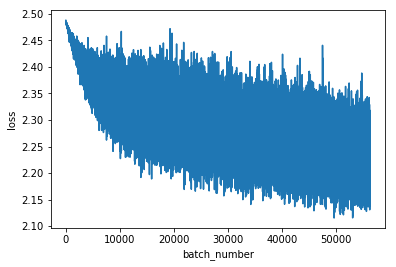

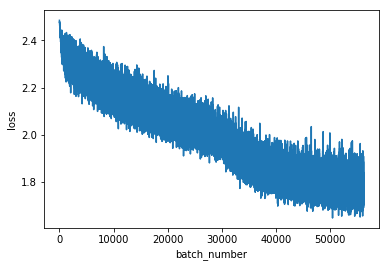

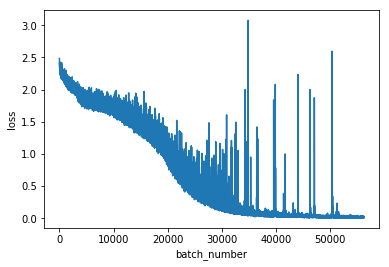

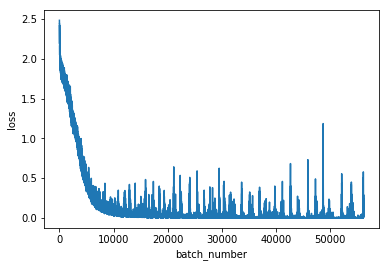

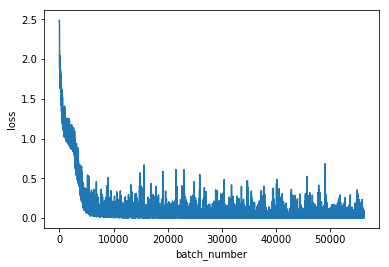

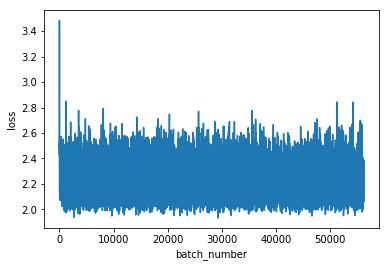

In [316]:
for i, model_info in enumerate(models_task2):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("loss")
    plot_losses_per_batch(model_info["history"])

# Plotarea acuratetii over time

Mai jos este plotata valoarea acuratetii-ului din fiecare batch.

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


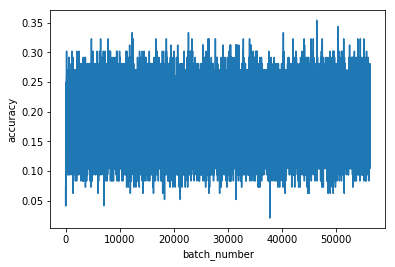

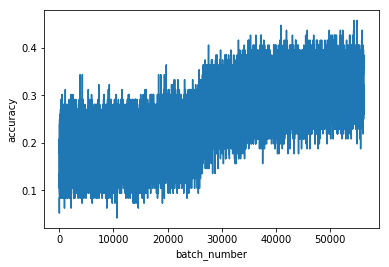

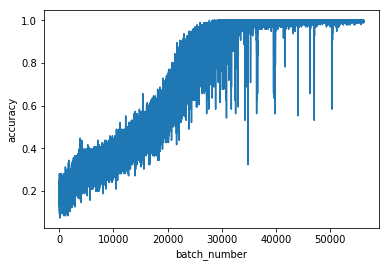

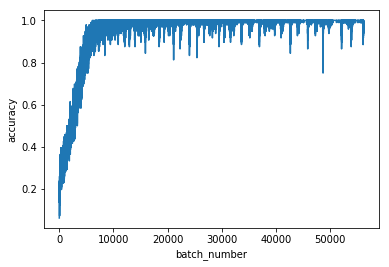

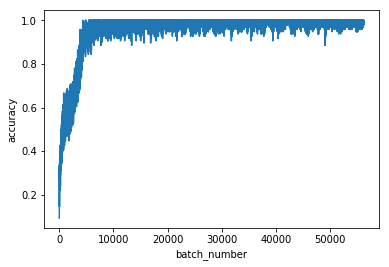

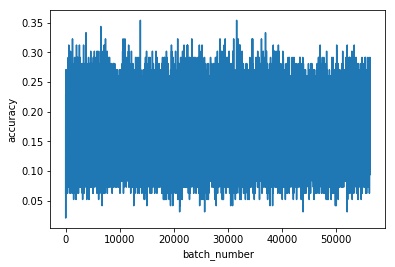

In [317]:
for i, model_info in enumerate(models_task2):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("accuracy")
    plot_accuracies_per_batch(model_info["history"])

In [318]:
for i, model_info in enumerate(models_task2):
    history = model_info['history']
    with open("task2_history_loss_model{}.txt".format(i), "w") as file:
        file.write(str(history.losses))
    with open("task2_history_acc_model{}.txt".format(i), "w") as file:
        file.write(str(history.accuracies))   

# Cateva exemple de prediction cu cel mai bun model

In [321]:
model = models_task2[2]["model"]

result = model.predict(X2_test[0:100], batch_size=32, verbose=0)

expected = [decode_data(x, alphabet) for x in y2_test[0:100]]
predicted = [decode_data(x, alphabet) for x in result]

for i in range(len(result)):
    print('Expected={}, Predicted={}'.format(expected[i], predicted[i]))

Expected=305, Predicted=305
Expected=110, Predicted=110
Expected=444, Predicted=444
Expected=255, Predicted=255
Expected=389, Predicted=389
Expected=448, Predicted=448
Expected=57 , Predicted=57 
Expected=232, Predicted=232
Expected=364, Predicted=364
Expected=438, Predicted=438
Expected=456, Predicted=456
Expected=449, Predicted=449
Expected=264, Predicted=264
Expected=376, Predicted=376
Expected=140, Predicted=140
Expected=349, Predicted=349
Expected=309, Predicted=309
Expected=474, Predicted=474
Expected=305, Predicted=305
Expected=377, Predicted=377
Expected=355, Predicted=355
Expected=309, Predicted=309
Expected=330, Predicted=330
Expected=237, Predicted=237
Expected=97 , Predicted=97 
Expected=221, Predicted=221
Expected=165, Predicted=165
Expected=196, Predicted=196
Expected=296, Predicted=296
Expected=259, Predicted=259
Expected=349, Predicted=349
Expected=383, Predicted=383
Expected=134, Predicted=134
Expected=225, Predicted=225
Expected=142, Predicted=142
Expected=371, Predic